# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data and survey information. I forecast Consumption growth and establish a benchmark model without the use of text data.

## Experiment Details

- **Data Sources:** Hard data and surveys.
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_hard_surveys_global_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_hard_surveys_global_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_hard_surveys_global_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_hard_surveys_global_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-9188.4
EM converged at iteration 65, llf=-8980.1, convergence criterion=9.8775e-07 < tolerance=1e-06
EM start iterations, llf=-9201.2
EM converged at iteration 65, llf=-8992.4, convergence criterion=9.8653e-07 < tolerance=1e-06
EM start iterations, llf=-9240.7
EM converged at iteration 65, llf=-9029.3, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-9247.5
EM converged at iteration 65, llf=-9036.4, convergence criterion=9.8451e-07 < tolerance=1e-06
EM start iterations, llf=-9297
EM converged at iteration 66, llf=-9080.8, convergence criterion=9.7228e-07 < tolerance=1e-06
EM start iterations, llf=-9305.4
EM converged at iteration 65, llf=-9087.9, convergence criterion=1e-06 < tolerance=1e-06
EM start iterations, llf=-9346.9
EM converged at iteration 65, llf=-9130.7, convergence criterion=9.987e-07 < tolerance=1e-06
EM start iterations, llf=-9346.9
EM converged at iteration 65, llf=-9130.7, convergence criterion=9.987e-07 < tolerance

EM converged at iteration 53, llf=-10390, convergence criterion=9.8806e-07 < tolerance=1e-06
EM start iterations, llf=-10575
EM converged at iteration 53, llf=-10417, convergence criterion=9.7643e-07 < tolerance=1e-06
EM start iterations, llf=-10623
EM converged at iteration 51, llf=-10476, convergence criterion=9.9102e-07 < tolerance=1e-06
EM start iterations, llf=-10629
EM converged at iteration 51, llf=-10479, convergence criterion=9.913e-07 < tolerance=1e-06
EM start iterations, llf=-10668
EM converged at iteration 51, llf=-10513, convergence criterion=9.8923e-07 < tolerance=1e-06
EM start iterations, llf=-10668
EM converged at iteration 51, llf=-10513, convergence criterion=9.8923e-07 < tolerance=1e-06
EM start iterations, llf=-10679
EM converged at iteration 51, llf=-10526, convergence criterion=9.9638e-07 < tolerance=1e-06
EM start iterations, llf=-10717
EM converged at iteration 51, llf=-10566, convergence criterion=9.9628e-07 < tolerance=1e-06
EM start iterations, llf=-10722
E

EM start iterations, llf=-11908
EM converged at iteration 54, llf=-11744, convergence criterion=9.8428e-07 < tolerance=1e-06
EM start iterations, llf=-11942
EM converged at iteration 54, llf=-11775, convergence criterion=9.8045e-07 < tolerance=1e-06
EM start iterations, llf=-11942
EM converged at iteration 54, llf=-11775, convergence criterion=9.8045e-07 < tolerance=1e-06
EM start iterations, llf=-11951
EM converged at iteration 54, llf=-11784, convergence criterion=9.7952e-07 < tolerance=1e-06
EM start iterations, llf=-11991
EM converged at iteration 54, llf=-11825, convergence criterion=9.7569e-07 < tolerance=1e-06
EM start iterations, llf=-12002
EM converged at iteration 54, llf=-11836, convergence criterion=9.7283e-07 < tolerance=1e-06
EM start iterations, llf=-12039
EM converged at iteration 54, llf=-11872, convergence criterion=9.8186e-07 < tolerance=1e-06
EM start iterations, llf=-12047
EM converged at iteration 54, llf=-11879, convergence criterion=9.7994e-07 < tolerance=1e-06


EM start iterations, llf=-13241
EM converged at iteration 64, llf=-13046, convergence criterion=9.8729e-07 < tolerance=1e-06
EM start iterations, llf=-13286
EM converged at iteration 64, llf=-13087, convergence criterion=9.8376e-07 < tolerance=1e-06
EM start iterations, llf=-13291
EM converged at iteration 64, llf=-13093, convergence criterion=9.8362e-07 < tolerance=1e-06
EM start iterations, llf=-13330
EM converged at iteration 64, llf=-13133, convergence criterion=9.9175e-07 < tolerance=1e-06
EM start iterations, llf=-13337
EM converged at iteration 64, llf=-13139, convergence criterion=9.9173e-07 < tolerance=1e-06
EM start iterations, llf=-13380
EM converged at iteration 64, llf=-13182, convergence criterion=9.8817e-07 < tolerance=1e-06
EM start iterations, llf=-13380
EM converged at iteration 64, llf=-13182, convergence criterion=9.8817e-07 < tolerance=1e-06
EM start iterations, llf=-13389
EM converged at iteration 64, llf=-13192, convergence criterion=9.8642e-07 < tolerance=1e-06


EM start iterations, llf=-14431
EM converged at iteration 65, llf=-14222, convergence criterion=9.8056e-07 < tolerance=1e-06
EM start iterations, llf=-14437
EM converged at iteration 65, llf=-14229, convergence criterion=9.806e-07 < tolerance=1e-06
EM start iterations, llf=-14483
EM converged at iteration 65, llf=-14273, convergence criterion=9.7696e-07 < tolerance=1e-06
EM start iterations, llf=-14483
EM converged at iteration 65, llf=-14273, convergence criterion=9.7696e-07 < tolerance=1e-06
EM start iterations, llf=-14488
EM converged at iteration 65, llf=-14279, convergence criterion=9.768e-07 < tolerance=1e-06
EM start iterations, llf=-14528
EM converged at iteration 65, llf=-14317, convergence criterion=9.7459e-07 < tolerance=1e-06
EM start iterations, llf=-14534
EM converged at iteration 65, llf=-14324, convergence criterion=9.7385e-07 < tolerance=1e-06
EM start iterations, llf=-14577
EM converged at iteration 65, llf=-14365, convergence criterion=9.7957e-07 < tolerance=1e-06
EM

EM start iterations, llf=-9623.1
EM converged at iteration 65, llf=-9391, convergence criterion=9.8655e-07 < tolerance=1e-06
EM start iterations, llf=-9623.1
EM converged at iteration 65, llf=-9391, convergence criterion=9.8655e-07 < tolerance=1e-06
EM start iterations, llf=-9605.4
EM converged at iteration 65, llf=-9370.9, convergence criterion=9.879e-07 < tolerance=1e-06
EM start iterations, llf=-9645.4
EM converged at iteration 65, llf=-9424, convergence criterion=9.9214e-07 < tolerance=1e-06
EM start iterations, llf=-9664.3
EM converged at iteration 65, llf=-9448.9, convergence criterion=9.8276e-07 < tolerance=1e-06
EM start iterations, llf=-9718.4
EM converged at iteration 66, llf=-9523.5, convergence criterion=9.7075e-07 < tolerance=1e-06
EM start iterations, llf=-9717.2
EM converged at iteration 65, llf=-9520.6, convergence criterion=9.9504e-07 < tolerance=1e-06
EM start iterations, llf=-9727.9
EM converged at iteration 64, llf=-9538.5, convergence criterion=9.6932e-07 < toleran

EM start iterations, llf=-11001
EM converged at iteration 62, llf=-10840, convergence criterion=9.6637e-07 < tolerance=1e-06
EM start iterations, llf=-11007
EM converged at iteration 60, llf=-10841, convergence criterion=9.806e-07 < tolerance=1e-06
EM start iterations, llf=-11033
EM converged at iteration 59, llf=-10859, convergence criterion=9.9663e-07 < tolerance=1e-06
EM start iterations, llf=-11039
EM converged at iteration 60, llf=-10871, convergence criterion=9.964e-07 < tolerance=1e-06
EM start iterations, llf=-11076
EM converged at iteration 63, llf=-10916, convergence criterion=9.7501e-07 < tolerance=1e-06
EM start iterations, llf=-11076
EM converged at iteration 63, llf=-10916, convergence criterion=9.7501e-07 < tolerance=1e-06
EM start iterations, llf=-11086
EM converged at iteration 63, llf=-10927, convergence criterion=9.7847e-07 < tolerance=1e-06
EM start iterations, llf=-11127
EM converged at iteration 62, llf=-10967, convergence criterion=9.9912e-07 < tolerance=1e-06
EM

EM start iterations, llf=-12336
EM converged at iteration 61, llf=-12160, convergence criterion=9.9904e-07 < tolerance=1e-06
EM start iterations, llf=-12376
EM converged at iteration 60, llf=-12196, convergence criterion=9.9202e-07 < tolerance=1e-06
EM start iterations, llf=-12376
EM converged at iteration 60, llf=-12196, convergence criterion=9.9202e-07 < tolerance=1e-06
EM start iterations, llf=-12384
EM converged at iteration 60, llf=-12204, convergence criterion=9.7763e-07 < tolerance=1e-06
EM start iterations, llf=-12424
EM converged at iteration 60, llf=-12241, convergence criterion=9.7536e-07 < tolerance=1e-06
EM start iterations, llf=-12426
EM converged at iteration 60, llf=-12243, convergence criterion=9.7769e-07 < tolerance=1e-06
EM start iterations, llf=-12468
EM converged at iteration 60, llf=-12284, convergence criterion=9.9199e-07 < tolerance=1e-06
EM start iterations, llf=-12472
EM converged at iteration 60, llf=-12288, convergence criterion=9.8976e-07 < tolerance=1e-06


EM start iterations, llf=-13687
EM converged at iteration 69, llf=-13494, convergence criterion=9.9785e-07 < tolerance=1e-06
EM start iterations, llf=-13725
EM converged at iteration 69, llf=-13531, convergence criterion=9.9693e-07 < tolerance=1e-06
EM start iterations, llf=-13730
EM converged at iteration 69, llf=-13537, convergence criterion=9.9589e-07 < tolerance=1e-06
EM start iterations, llf=-13772
EM converged at iteration 69, llf=-13577, convergence criterion=9.9831e-07 < tolerance=1e-06
EM start iterations, llf=-13779
EM converged at iteration 69, llf=-13584, convergence criterion=9.9424e-07 < tolerance=1e-06
EM start iterations, llf=-13815
EM converged at iteration 69, llf=-13619, convergence criterion=9.9155e-07 < tolerance=1e-06
EM start iterations, llf=-13815
EM converged at iteration 69, llf=-13619, convergence criterion=9.9155e-07 < tolerance=1e-06
EM start iterations, llf=-13834
EM converged at iteration 69, llf=-13638, convergence criterion=9.9116e-07 < tolerance=1e-06


EM start iterations, llf=-14858
EM converged at iteration 69, llf=-14635, convergence criterion=9.7888e-07 < tolerance=1e-06
EM start iterations, llf=-14868
EM converged at iteration 69, llf=-14647, convergence criterion=9.7887e-07 < tolerance=1e-06
EM start iterations, llf=-14905
EM converged at iteration 69, llf=-14685, convergence criterion=9.7494e-07 < tolerance=1e-06
EM start iterations, llf=-14905
EM converged at iteration 69, llf=-14685, convergence criterion=9.7494e-07 < tolerance=1e-06
EM start iterations, llf=-14913
EM converged at iteration 69, llf=-14694, convergence criterion=9.7601e-07 < tolerance=1e-06
EM start iterations, llf=-14957
EM converged at iteration 69, llf=-14738, convergence criterion=9.76e-07 < tolerance=1e-06
EM start iterations, llf=-14965
EM converged at iteration 69, llf=-14745, convergence criterion=9.7485e-07 < tolerance=1e-06
EM start iterations, llf=-15004
EM converged at iteration 68, llf=-14784, convergence criterion=9.8832e-07 < tolerance=1e-06
EM

EM start iterations, llf=-10026
EM converged at iteration 64, llf=-9846, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-10026
EM converged at iteration 64, llf=-9846, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-10032
EM converged at iteration 64, llf=-9852.3, convergence criterion=9.7824e-07 < tolerance=1e-06
EM start iterations, llf=-10068
EM converged at iteration 64, llf=-9886.7, convergence criterion=9.6667e-07 < tolerance=1e-06
EM start iterations, llf=-10075
EM converged at iteration 64, llf=-9893.8, convergence criterion=9.676e-07 < tolerance=1e-06
EM start iterations, llf=-10105
EM converged at iteration 60, llf=-9918.6, convergence criterion=9.7773e-07 < tolerance=1e-06
EM start iterations, llf=-10116
EM converged at iteration 60, llf=-9928.5, convergence criterion=9.7064e-07 < tolerance=1e-06
EM start iterations, llf=-10163
EM converged at iteration 61, llf=-9983.9, convergence criterion=9.8145e-07 < tolerance=1e-

EM start iterations, llf=-11411
EM converged at iteration 64, llf=-11247, convergence criterion=9.6831e-07 < tolerance=1e-06
EM start iterations, llf=-11415
EM converged at iteration 64, llf=-11252, convergence criterion=9.6996e-07 < tolerance=1e-06
EM start iterations, llf=-11461
EM converged at iteration 64, llf=-11301, convergence criterion=9.8157e-07 < tolerance=1e-06
EM start iterations, llf=-11470
EM converged at iteration 64, llf=-11307, convergence criterion=9.6788e-07 < tolerance=1e-06
EM start iterations, llf=-11512
EM converged at iteration 64, llf=-11350, convergence criterion=9.8019e-07 < tolerance=1e-06
EM start iterations, llf=-11512
EM converged at iteration 64, llf=-11350, convergence criterion=9.8019e-07 < tolerance=1e-06
EM start iterations, llf=-11519
EM converged at iteration 64, llf=-11357, convergence criterion=9.7024e-07 < tolerance=1e-06
EM start iterations, llf=-11561
EM converged at iteration 63, llf=-11398, convergence criterion=9.9762e-07 < tolerance=1e-06


EM start iterations, llf=-12758
EM converged at iteration 62, llf=-12576, convergence criterion=9.6839e-07 < tolerance=1e-06
EM start iterations, llf=-12802
EM converged at iteration 62, llf=-12619, convergence criterion=9.6563e-07 < tolerance=1e-06
EM start iterations, llf=-12802
EM converged at iteration 62, llf=-12619, convergence criterion=9.6563e-07 < tolerance=1e-06
EM start iterations, llf=-12811
EM converged at iteration 61, llf=-12627, convergence criterion=9.9806e-07 < tolerance=1e-06
EM start iterations, llf=-12852
EM converged at iteration 61, llf=-12666, convergence criterion=9.9112e-07 < tolerance=1e-06
EM start iterations, llf=-12861
EM converged at iteration 61, llf=-12676, convergence criterion=9.8918e-07 < tolerance=1e-06
EM start iterations, llf=-12898
EM converged at iteration 61, llf=-12713, convergence criterion=9.8376e-07 < tolerance=1e-06
EM start iterations, llf=-12906
EM converged at iteration 61, llf=-12720, convergence criterion=9.8036e-07 < tolerance=1e-06


EM start iterations, llf=-14104
EM converged at iteration 69, llf=-13902, convergence criterion=9.8759e-07 < tolerance=1e-06
EM start iterations, llf=-14141
EM converged at iteration 69, llf=-13940, convergence criterion=9.8708e-07 < tolerance=1e-06
EM start iterations, llf=-14148
EM converged at iteration 69, llf=-13948, convergence criterion=9.8797e-07 < tolerance=1e-06
EM start iterations, llf=-14187
EM converged at iteration 70, llf=-13986, convergence criterion=9.7252e-07 < tolerance=1e-06
EM start iterations, llf=-14194
EM converged at iteration 70, llf=-13993, convergence criterion=9.719e-07 < tolerance=1e-06
EM start iterations, llf=-14236
EM converged at iteration 69, llf=-14034, convergence criterion=9.9973e-07 < tolerance=1e-06
EM start iterations, llf=-14236
EM converged at iteration 69, llf=-14034, convergence criterion=9.9973e-07 < tolerance=1e-06
EM start iterations, llf=-14240
EM converged at iteration 69, llf=-14037, convergence criterion=9.9686e-07 < tolerance=1e-06
E

EM start iterations, llf=-15003
EM converged at iteration 71, llf=-14777, convergence criterion=9.74e-07 < tolerance=1e-06
EM start iterations, llf=-15007
EM converged at iteration 71, llf=-14782, convergence criterion=9.7353e-07 < tolerance=1e-06
EM start iterations, llf=-15048
EM converged at iteration 71, llf=-14823, convergence criterion=9.7237e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 1:38:49.572501.
EM start iterations, llf=-8713
EM converged at iteration 63, llf=-8604.7, convergence criterion=9.8992e-07 < tolerance=1e-06
EM start iterations, llf=-8725.9
EM converged at iteration 63, llf=-8617.3, convergence criterion=9.9132e-07 < tolerance=1e-06
EM start iterations, llf=-8764
EM converged at iteration 63, llf=-8655.7, convergence criterion=9.7862e-07 < tolerance=1e-06
EM start iterations, llf=-8771.9
EM converged at iteration 63, llf=-8663.5, convergence criterion=9.7735e-07 < tolerance=1e-06
EM start iterations, llf=-8814.6
EM converged at i

EM converged at iteration 55, llf=-9735.6, convergence criterion=9.8059e-07 < tolerance=1e-06
EM start iterations, llf=-9874.4
EM converged at iteration 55, llf=-9763.4, convergence criterion=9.8713e-07 < tolerance=1e-06
EM start iterations, llf=-9874.4
EM converged at iteration 55, llf=-9763.4, convergence criterion=9.8713e-07 < tolerance=1e-06
EM start iterations, llf=-9887.4
EM converged at iteration 55, llf=-9775.7, convergence criterion=9.882e-07 < tolerance=1e-06
EM start iterations, llf=-9909.4
EM converged at iteration 55, llf=-9797.3, convergence criterion=9.8234e-07 < tolerance=1e-06
EM start iterations, llf=-9916.4
EM converged at iteration 55, llf=-9801.7, convergence criterion=9.8264e-07 < tolerance=1e-06
EM start iterations, llf=-9960.5
EM converged at iteration 53, llf=-9839.9, convergence criterion=9.878e-07 < tolerance=1e-06
EM start iterations, llf=-9965
EM converged at iteration 53, llf=-9846.8, convergence criterion=9.841e-07 < tolerance=1e-06
EM start iterations, l

EM start iterations, llf=-11086
EM converged at iteration 50, llf=-10965, convergence criterion=9.9551e-07 < tolerance=1e-06
EM start iterations, llf=-11120
EM converged at iteration 50, llf=-11001, convergence criterion=9.8926e-07 < tolerance=1e-06
EM start iterations, llf=-11132
EM converged at iteration 50, llf=-11010, convergence criterion=9.8259e-07 < tolerance=1e-06
EM start iterations, llf=-11173
EM converged at iteration 53, llf=-11051, convergence criterion=9.86e-07 < tolerance=1e-06
EM start iterations, llf=-11181
EM converged at iteration 53, llf=-11059, convergence criterion=9.8558e-07 < tolerance=1e-06
EM start iterations, llf=-11216
EM converged at iteration 53, llf=-11094, convergence criterion=9.7887e-07 < tolerance=1e-06
EM start iterations, llf=-11216
EM converged at iteration 53, llf=-11094, convergence criterion=9.7887e-07 < tolerance=1e-06
EM start iterations, llf=-11223
EM converged at iteration 53, llf=-11103, convergence criterion=9.7876e-07 < tolerance=1e-06
EM

EM start iterations, llf=-12408
EM converged at iteration 64, llf=-12280, convergence criterion=9.8502e-07 < tolerance=1e-06
EM start iterations, llf=-12416
EM converged at iteration 64, llf=-12288, convergence criterion=9.839e-07 < tolerance=1e-06
EM start iterations, llf=-12447
EM converged at iteration 64, llf=-12320, convergence criterion=9.8252e-07 < tolerance=1e-06
EM start iterations, llf=-12447
EM converged at iteration 64, llf=-12320, convergence criterion=9.8252e-07 < tolerance=1e-06
EM start iterations, llf=-12461
EM converged at iteration 64, llf=-12333, convergence criterion=9.8077e-07 < tolerance=1e-06
EM start iterations, llf=-12504
EM converged at iteration 64, llf=-12377, convergence criterion=9.8072e-07 < tolerance=1e-06
EM start iterations, llf=-12506
EM converged at iteration 64, llf=-12380, convergence criterion=9.8208e-07 < tolerance=1e-06
EM start iterations, llf=-12545
EM converged at iteration 64, llf=-12419, convergence criterion=9.8621e-07 < tolerance=1e-06
E

EM start iterations, llf=-13484
EM converged at iteration 65, llf=-13355, convergence criterion=9.9025e-07 < tolerance=1e-06
EM start iterations, llf=-13490
EM converged at iteration 65, llf=-13360, convergence criterion=9.877e-07 < tolerance=1e-06
EM start iterations, llf=-13525
EM converged at iteration 65, llf=-13395, convergence criterion=9.8473e-07 < tolerance=1e-06
EM start iterations, llf=-13539
EM converged at iteration 65, llf=-13409, convergence criterion=9.8267e-07 < tolerance=1e-06
EM start iterations, llf=-13583
EM converged at iteration 65, llf=-13452, convergence criterion=9.8694e-07 < tolerance=1e-06
EM start iterations, llf=-13589
EM converged at iteration 65, llf=-13457, convergence criterion=9.8621e-07 < tolerance=1e-06
EM start iterations, llf=-13631
EM converged at iteration 65, llf=-13500, convergence criterion=9.8103e-07 < tolerance=1e-06
EM start iterations, llf=-13631
EM converged at iteration 65, llf=-13500, convergence criterion=9.8103e-07 < tolerance=1e-06
E

EM start iterations, llf=-9022.2
EM converged at iteration 79, llf=-8909.2, convergence criterion=9.8049e-07 < tolerance=1e-06
EM start iterations, llf=-9033
EM converged at iteration 81, llf=-8919.8, convergence criterion=9.9486e-07 < tolerance=1e-06
EM start iterations, llf=-9056.2
EM converged at iteration 76, llf=-8944.6, convergence criterion=9.8599e-07 < tolerance=1e-06
EM start iterations, llf=-9058.9
EM converged at iteration 75, llf=-8946.2, convergence criterion=9.7645e-07 < tolerance=1e-06
EM start iterations, llf=-9112.7
EM converged at iteration 70, llf=-9000.7, convergence criterion=9.9767e-07 < tolerance=1e-06
EM start iterations, llf=-9112.7
EM converged at iteration 70, llf=-9000.7, convergence criterion=9.9767e-07 < tolerance=1e-06
EM start iterations, llf=-9124.5
EM converged at iteration 72, llf=-9013.9, convergence criterion=9.7892e-07 < tolerance=1e-06
EM start iterations, llf=-9176.9
EM converged at iteration 71, llf=-9072.2, convergence criterion=9.8363e-07 < to

EM start iterations, llf=-10222
EM converged at iteration 65, llf=-10101, convergence criterion=9.7269e-07 < tolerance=1e-06
EM start iterations, llf=-10230
EM converged at iteration 64, llf=-10109, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-10265
EM converged at iteration 64, llf=-10142, convergence criterion=9.8106e-07 < tolerance=1e-06
EM start iterations, llf=-10265
EM converged at iteration 64, llf=-10142, convergence criterion=9.8106e-07 < tolerance=1e-06
EM start iterations, llf=-10273
EM converged at iteration 63, llf=-10153, convergence criterion=9.9432e-07 < tolerance=1e-06
EM start iterations, llf=-10307
EM converged at iteration 64, llf=-10186, convergence criterion=9.8107e-07 < tolerance=1e-06
EM start iterations, llf=-10316
EM converged at iteration 64, llf=-10195, convergence criterion=9.7669e-07 < tolerance=1e-06
EM start iterations, llf=-10348
EM converged at iteration 64, llf=-10226, convergence criterion=9.9028e-07 < tolerance=1e-06


EM start iterations, llf=-11484
EM converged at iteration 60, llf=-11363, convergence criterion=9.7917e-07 < tolerance=1e-06
EM start iterations, llf=-11496
EM converged at iteration 59, llf=-11375, convergence criterion=9.8684e-07 < tolerance=1e-06
EM start iterations, llf=-11533
EM converged at iteration 59, llf=-11412, convergence criterion=9.8827e-07 < tolerance=1e-06
EM start iterations, llf=-11542
EM converged at iteration 59, llf=-11421, convergence criterion=9.9086e-07 < tolerance=1e-06
EM start iterations, llf=-11581
EM converged at iteration 58, llf=-11461, convergence criterion=9.9167e-07 < tolerance=1e-06
EM start iterations, llf=-11588
EM converged at iteration 58, llf=-11467, convergence criterion=9.9763e-07 < tolerance=1e-06
EM start iterations, llf=-11620
EM converged at iteration 58, llf=-11501, convergence criterion=9.955e-07 < tolerance=1e-06
EM start iterations, llf=-11620
EM converged at iteration 58, llf=-11501, convergence criterion=9.955e-07 < tolerance=1e-06
EM

EM start iterations, llf=-12773
EM converged at iteration 69, llf=-12644, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-12813
EM converged at iteration 70, llf=-12683, convergence criterion=9.9999e-07 < tolerance=1e-06
EM start iterations, llf=-12821
EM converged at iteration 70, llf=-12691, convergence criterion=9.9684e-07 < tolerance=1e-06
EM start iterations, llf=-12857
EM converged at iteration 70, llf=-12728, convergence criterion=9.9368e-07 < tolerance=1e-06
EM start iterations, llf=-12857
EM converged at iteration 70, llf=-12728, convergence criterion=9.9368e-07 < tolerance=1e-06
EM start iterations, llf=-12866
EM converged at iteration 70, llf=-12736, convergence criterion=9.9556e-07 < tolerance=1e-06
EM start iterations, llf=-12902
EM converged at iteration 70, llf=-12771, convergence criterion=9.9553e-07 < tolerance=1e-06
EM start iterations, llf=-12906
EM converged at iteration 70, llf=-12775, convergence criterion=9.9549e-07 < tolerance=1e-06


EM start iterations, llf=-13896
EM converged at iteration 70, llf=-13765, convergence criterion=9.898e-07 < tolerance=1e-06
EM start iterations, llf=-13896
EM converged at iteration 70, llf=-13765, convergence criterion=9.898e-07 < tolerance=1e-06
EM start iterations, llf=-13905
EM converged at iteration 70, llf=-13774, convergence criterion=9.8689e-07 < tolerance=1e-06
EM start iterations, llf=-13941
EM converged at iteration 70, llf=-13809, convergence criterion=9.8714e-07 < tolerance=1e-06
EM start iterations, llf=-13949
EM converged at iteration 70, llf=-13816, convergence criterion=9.8537e-07 < tolerance=1e-06
EM start iterations, llf=-13984
EM converged at iteration 70, llf=-13852, convergence criterion=9.8868e-07 < tolerance=1e-06
EM start iterations, llf=-13992
EM converged at iteration 70, llf=-13859, convergence criterion=9.8426e-07 < tolerance=1e-06
EM start iterations, llf=-14025
EM converged at iteration 70, llf=-13891, convergence criterion=9.8313e-07 < tolerance=1e-06
EM

EM start iterations, llf=-9292.4
EM converged at iteration 84, llf=-9166.8, convergence criterion=9.9998e-07 < tolerance=1e-06
EM start iterations, llf=-9328.2
EM converged at iteration 77, llf=-9206.9, convergence criterion=9.9108e-07 < tolerance=1e-06
EM start iterations, llf=-9339.4
EM converged at iteration 81, llf=-9222.7, convergence criterion=9.8743e-07 < tolerance=1e-06
EM start iterations, llf=-9391.6
EM converged at iteration 78, llf=-9275.9, convergence criterion=9.8068e-07 < tolerance=1e-06
EM start iterations, llf=-9408
EM converged at iteration 76, llf=-9287.4, convergence criterion=9.9414e-07 < tolerance=1e-06
EM start iterations, llf=-9443
EM converged at iteration 76, llf=-9322.8, convergence criterion=9.7987e-07 < tolerance=1e-06
EM start iterations, llf=-9443
EM converged at iteration 76, llf=-9322.8, convergence criterion=9.7987e-07 < tolerance=1e-06
EM start iterations, llf=-9444
EM converged at iteration 78, llf=-9326.1, convergence criterion=9.9925e-07 < toleranc

EM converged at iteration 75, llf=-10446, convergence criterion=9.8522e-07 < tolerance=1e-06
EM start iterations, llf=-10593
EM converged at iteration 74, llf=-10472, convergence criterion=9.9417e-07 < tolerance=1e-06
EM start iterations, llf=-10611
EM converged at iteration 73, llf=-10492, convergence criterion=9.9757e-07 < tolerance=1e-06
EM start iterations, llf=-10645
EM converged at iteration 75, llf=-10524, convergence criterion=9.8699e-07 < tolerance=1e-06
EM start iterations, llf=-10645
EM converged at iteration 75, llf=-10524, convergence criterion=9.8699e-07 < tolerance=1e-06
EM start iterations, llf=-10651
EM converged at iteration 75, llf=-10530, convergence criterion=9.9387e-07 < tolerance=1e-06
EM start iterations, llf=-10699
EM converged at iteration 74, llf=-10578, convergence criterion=9.8243e-07 < tolerance=1e-06
EM start iterations, llf=-10705
EM converged at iteration 73, llf=-10584, convergence criterion=9.9685e-07 < tolerance=1e-06
EM start iterations, llf=-10747


EM start iterations, llf=-11894
EM converged at iteration 68, llf=-11770, convergence criterion=9.8465e-07 < tolerance=1e-06
EM start iterations, llf=-11894
EM converged at iteration 68, llf=-11770, convergence criterion=9.8465e-07 < tolerance=1e-06
EM start iterations, llf=-11901
EM converged at iteration 68, llf=-11779, convergence criterion=9.9361e-07 < tolerance=1e-06
EM start iterations, llf=-11942
EM converged at iteration 68, llf=-11819, convergence criterion=9.7502e-07 < tolerance=1e-06
EM start iterations, llf=-11946
EM converged at iteration 68, llf=-11823, convergence criterion=9.7384e-07 < tolerance=1e-06
EM start iterations, llf=-11989
EM converged at iteration 68, llf=-11865, convergence criterion=9.7438e-07 < tolerance=1e-06
EM start iterations, llf=-11993
EM converged at iteration 68, llf=-11870, convergence criterion=9.7585e-07 < tolerance=1e-06
EM start iterations, llf=-12036
EM converged at iteration 68, llf=-11912, convergence criterion=9.9096e-07 < tolerance=1e-06


EM start iterations, llf=-13171
EM converged at iteration 82, llf=-13040, convergence criterion=9.7968e-07 < tolerance=1e-06
EM start iterations, llf=-13180
EM converged at iteration 82, llf=-13050, convergence criterion=9.7827e-07 < tolerance=1e-06
EM start iterations, llf=-13225
EM converged at iteration 82, llf=-13093, convergence criterion=9.8943e-07 < tolerance=1e-06
EM start iterations, llf=-13231
EM converged at iteration 82, llf=-13099, convergence criterion=9.9213e-07 < tolerance=1e-06
EM start iterations, llf=-13268
EM converged at iteration 82, llf=-13136, convergence criterion=9.9147e-07 < tolerance=1e-06
EM start iterations, llf=-13268
EM converged at iteration 82, llf=-13136, convergence criterion=9.9147e-07 < tolerance=1e-06
EM start iterations, llf=-13274
EM converged at iteration 82, llf=-13143, convergence criterion=9.9464e-07 < tolerance=1e-06
EM start iterations, llf=-13309
EM converged at iteration 82, llf=-13177, convergence criterion=9.7885e-07 < tolerance=1e-06


EM start iterations, llf=-14263
EM converged at iteration 79, llf=-14125, convergence criterion=9.951e-07 < tolerance=1e-06
EM start iterations, llf=-14294
EM converged at iteration 79, llf=-14155, convergence criterion=9.9426e-07 < tolerance=1e-06
EM start iterations, llf=-14294
EM converged at iteration 79, llf=-14155, convergence criterion=9.9426e-07 < tolerance=1e-06
EM start iterations, llf=-14014
EM converged at iteration 81, llf=-13884, convergence criterion=9.9295e-07 < tolerance=1e-06
EM start iterations, llf=-14054
EM converged at iteration 80, llf=-13925, convergence criterion=9.9003e-07 < tolerance=1e-06
EM start iterations, llf=-14065
EM converged at iteration 80, llf=-13936, convergence criterion=9.8782e-07 < tolerance=1e-06
EM start iterations, llf=-14107
EM converged at iteration 80, llf=-13977, convergence criterion=9.9229e-07 < tolerance=1e-06
EM start iterations, llf=-14111
EM converged at iteration 80, llf=-13981, convergence criterion=9.9288e-07 < tolerance=1e-06
E

EM converged at iteration 62, llf=-9348.5, convergence criterion=9.841e-07 < tolerance=1e-06
EM start iterations, llf=-9538.4
EM converged at iteration 61, llf=-9386.8, convergence criterion=9.7056e-07 < tolerance=1e-06
EM start iterations, llf=-9538.4
EM converged at iteration 61, llf=-9386.8, convergence criterion=9.7056e-07 < tolerance=1e-06
EM start iterations, llf=-9551.3
EM converged at iteration 61, llf=-9398.4, convergence criterion=9.7544e-07 < tolerance=1e-06
EM start iterations, llf=-9581.8
EM converged at iteration 60, llf=-9430.6, convergence criterion=9.8269e-07 < tolerance=1e-06
EM start iterations, llf=-9584.7
EM converged at iteration 60, llf=-9437.9, convergence criterion=9.7526e-07 < tolerance=1e-06
EM start iterations, llf=-9616.2
EM converged at iteration 63, llf=-9469.7, convergence criterion=9.7066e-07 < tolerance=1e-06
EM start iterations, llf=-9662.7
EM converged at iteration 63, llf=-9515.4, convergence criterion=9.8381e-07 < tolerance=1e-06
EM start iteration

EM start iterations, llf=-10722
EM converged at iteration 66, llf=-10555, convergence criterion=9.7424e-07 < tolerance=1e-06
EM start iterations, llf=-10753
EM converged at iteration 65, llf=-10586, convergence criterion=9.8958e-07 < tolerance=1e-06
EM start iterations, llf=-10758
EM converged at iteration 65, llf=-10591, convergence criterion=9.8451e-07 < tolerance=1e-06
EM start iterations, llf=-10799
EM converged at iteration 67, llf=-10633, convergence criterion=9.7983e-07 < tolerance=1e-06
EM start iterations, llf=-10807
EM converged at iteration 67, llf=-10639, convergence criterion=9.8384e-07 < tolerance=1e-06
EM start iterations, llf=-10844
EM converged at iteration 66, llf=-10678, convergence criterion=9.9241e-07 < tolerance=1e-06
EM start iterations, llf=-10844
EM converged at iteration 66, llf=-10678, convergence criterion=9.9241e-07 < tolerance=1e-06
EM start iterations, llf=-10848
EM converged at iteration 66, llf=-10683, convergence criterion=9.9661e-07 < tolerance=1e-06


EM start iterations, llf=-12025
EM converged at iteration 65, llf=-11851, convergence criterion=9.747e-07 < tolerance=1e-06
EM start iterations, llf=-12036
EM converged at iteration 77, llf=-11860, convergence criterion=9.9148e-07 < tolerance=1e-06
EM start iterations, llf=-12069
EM converged at iteration 77, llf=-11894, convergence criterion=9.9196e-07 < tolerance=1e-06
EM start iterations, llf=-12069
EM converged at iteration 77, llf=-11894, convergence criterion=9.9196e-07 < tolerance=1e-06
EM start iterations, llf=-12080
EM converged at iteration 77, llf=-11902, convergence criterion=9.8104e-07 < tolerance=1e-06
EM start iterations, llf=-12117
EM converged at iteration 77, llf=-11938, convergence criterion=9.8307e-07 < tolerance=1e-06
EM start iterations, llf=-12118
EM converged at iteration 76, llf=-11941, convergence criterion=9.9805e-07 < tolerance=1e-06
EM start iterations, llf=-12159
EM converged at iteration 76, llf=-11981, convergence criterion=9.9255e-07 < tolerance=1e-06
E

EM start iterations, llf=-13279
EM converged at iteration 76, llf=-13089, convergence criterion=9.8609e-07 < tolerance=1e-06
EM start iterations, llf=-13291
EM converged at iteration 76, llf=-13101, convergence criterion=9.834e-07 < tolerance=1e-06
EM start iterations, llf=-13328
EM converged at iteration 76, llf=-13140, convergence criterion=9.8538e-07 < tolerance=1e-06
EM start iterations, llf=-13334
EM converged at iteration 76, llf=-13150, convergence criterion=9.8432e-07 < tolerance=1e-06
EM start iterations, llf=-13355
EM converged at iteration 75, llf=-13179, convergence criterion=9.8165e-07 < tolerance=1e-06
EM start iterations, llf=-13374
EM converged at iteration 75, llf=-13192, convergence criterion=9.9184e-07 < tolerance=1e-06
EM start iterations, llf=-13175
EM converged at iteration 75, llf=-13014, convergence criterion=9.8005e-07 < tolerance=1e-06
EM start iterations, llf=-13175
EM converged at iteration 75, llf=-13014, convergence criterion=9.8005e-07 < tolerance=1e-06
E

EM start iterations, llf=-8663.4
EM converged at iteration 87, llf=-8569.8, convergence criterion=9.8389e-07 < tolerance=1e-06
EM start iterations, llf=-8668
EM converged at iteration 83, llf=-8575.1, convergence criterion=9.8522e-07 < tolerance=1e-06
EM start iterations, llf=-8720.5
EM converged at iteration 76, llf=-8625, convergence criterion=9.7899e-07 < tolerance=1e-06
EM start iterations, llf=-8719
EM converged at iteration 78, llf=-8625.1, convergence criterion=9.8644e-07 < tolerance=1e-06
EM start iterations, llf=-8771.5
EM converged at iteration 71, llf=-8673.3, convergence criterion=9.968e-07 < tolerance=1e-06
EM start iterations, llf=-8771.5
EM converged at iteration 71, llf=-8673.3, convergence criterion=9.968e-07 < tolerance=1e-06
EM start iterations, llf=-8786.3
EM converged at iteration 70, llf=-8686.9, convergence criterion=9.7869e-07 < tolerance=1e-06
EM start iterations, llf=-8836.2
EM converged at iteration 69, llf=-8731.1, convergence criterion=9.9276e-07 < toleranc

EM start iterations, llf=-9824.5
EM converged at iteration 61, llf=-9678.7, convergence criterion=9.884e-07 < tolerance=1e-06
EM start iterations, llf=-9870.2
EM converged at iteration 66, llf=-9716.6, convergence criterion=9.7968e-07 < tolerance=1e-06
EM start iterations, llf=-9880.6
EM converged at iteration 66, llf=-9727.4, convergence criterion=9.717e-07 < tolerance=1e-06
EM start iterations, llf=-9918.2
EM converged at iteration 65, llf=-9765, convergence criterion=9.9985e-07 < tolerance=1e-06
EM start iterations, llf=-9918.2
EM converged at iteration 65, llf=-9765, convergence criterion=9.9985e-07 < tolerance=1e-06
EM start iterations, llf=-9926.4
EM converged at iteration 65, llf=-9773.1, convergence criterion=9.8651e-07 < tolerance=1e-06
EM start iterations, llf=-9960.1
EM converged at iteration 63, llf=-9807.1, convergence criterion=9.9248e-07 < tolerance=1e-06
EM start iterations, llf=-9968.3
EM converged at iteration 63, llf=-9817, convergence criterion=9.7823e-07 < toleranc

EM start iterations, llf=-11057
EM converged at iteration 72, llf=-10893, convergence criterion=9.9916e-07 < tolerance=1e-06
EM start iterations, llf=-11089
EM converged at iteration 71, llf=-10925, convergence criterion=9.8546e-07 < tolerance=1e-06
EM start iterations, llf=-11089
EM converged at iteration 71, llf=-10925, convergence criterion=9.8546e-07 < tolerance=1e-06
EM start iterations, llf=-11101
EM converged at iteration 71, llf=-10937, convergence criterion=9.8678e-07 < tolerance=1e-06
EM start iterations, llf=-11125
EM converged at iteration 72, llf=-10961, convergence criterion=9.8432e-07 < tolerance=1e-06
EM start iterations, llf=-11134
EM converged at iteration 72, llf=-10972, convergence criterion=9.9308e-07 < tolerance=1e-06
EM start iterations, llf=-11182
EM converged at iteration 74, llf=-11020, convergence criterion=9.826e-07 < tolerance=1e-06
EM start iterations, llf=-11194
EM converged at iteration 74, llf=-11033, convergence criterion=9.8637e-07 < tolerance=1e-06
E

EM start iterations, llf=-12337
EM converged at iteration 81, llf=-12158, convergence criterion=9.9659e-07 < tolerance=1e-06
EM start iterations, llf=-12377
EM converged at iteration 80, llf=-12196, convergence criterion=9.8696e-07 < tolerance=1e-06
EM start iterations, llf=-12387
EM converged at iteration 81, llf=-12207, convergence criterion=9.8084e-07 < tolerance=1e-06
EM start iterations, llf=-12423
EM converged at iteration 79, llf=-12242, convergence criterion=9.9477e-07 < tolerance=1e-06
EM start iterations, llf=-12433
EM converged at iteration 79, llf=-12251, convergence criterion=9.9901e-07 < tolerance=1e-06
EM start iterations, llf=-12468
EM converged at iteration 80, llf=-12286, convergence criterion=9.9214e-07 < tolerance=1e-06
EM start iterations, llf=-12468
EM converged at iteration 80, llf=-12286, convergence criterion=9.9214e-07 < tolerance=1e-06
EM start iterations, llf=-12476
EM converged at iteration 81, llf=-12295, convergence criterion=9.841e-07 < tolerance=1e-06
E

EM start iterations, llf=-13423
EM converged at iteration 83, llf=-13247, convergence criterion=9.8302e-07 < tolerance=1e-06
EM start iterations, llf=-13431
EM converged at iteration 83, llf=-13254, convergence criterion=9.8205e-07 < tolerance=1e-06
EM start iterations, llf=-13468
EM converged at iteration 82, llf=-13292, convergence criterion=9.8743e-07 < tolerance=1e-06
EM start iterations, llf=-13468
EM converged at iteration 82, llf=-13292, convergence criterion=9.8743e-07 < tolerance=1e-06
EM start iterations, llf=-13475
EM converged at iteration 82, llf=-13298, convergence criterion=9.8742e-07 < tolerance=1e-06
EM start iterations, llf=-13518
EM converged at iteration 81, llf=-13341, convergence criterion=9.9316e-07 < tolerance=1e-06
EM start iterations, llf=-13520
EM converged at iteration 82, llf=-13344, convergence criterion=9.898e-07 < tolerance=1e-06
EM start iterations, llf=-13553
EM converged at iteration 82, llf=-13379, convergence criterion=9.9803e-07 < tolerance=1e-06
E

EM converged at iteration 92, llf=-8827.5, convergence criterion=9.9782e-07 < tolerance=1e-06
EM start iterations, llf=-8918.2
EM converged at iteration 87, llf=-8819.1, convergence criterion=9.9131e-07 < tolerance=1e-06
EM start iterations, llf=-8919.3
EM converged at iteration 91, llf=-8823.4, convergence criterion=9.9145e-07 < tolerance=1e-06
EM start iterations, llf=-8953.3
EM converged at iteration 90, llf=-8849.8, convergence criterion=9.8463e-07 < tolerance=1e-06
EM start iterations, llf=-8953.3
EM converged at iteration 90, llf=-8849.8, convergence criterion=9.8463e-07 < tolerance=1e-06
EM start iterations, llf=-8920.9
EM converged at iteration 83, llf=-8822.2, convergence criterion=9.92e-07 < tolerance=1e-06
EM start iterations, llf=-9002.2
EM converged at iteration 82, llf=-8864.6, convergence criterion=9.7826e-07 < tolerance=1e-06
EM start iterations, llf=-9014.9
EM converged at iteration 83, llf=-8868.6, convergence criterion=9.8511e-07 < tolerance=1e-06
EM start iterations

EM converged at iteration 118, llf=-9895.4, convergence criterion=9.898e-07 < tolerance=1e-06
EM start iterations, llf=-10067
EM iteration 100, llf=-9944, convergence criterion=1.0145e-06
EM converged at iteration 101, llf=-9944, convergence criterion=9.9993e-07 < tolerance=1e-06
EM start iterations, llf=-10066
EM iteration 100, llf=-9919.1, convergence criterion=1.1924e-06
EM converged at iteration 111, llf=-9918.9, convergence criterion=9.9724e-07 < tolerance=1e-06
EM start iterations, llf=-10135
EM converged at iteration 91, llf=-9969.2, convergence criterion=9.9269e-07 < tolerance=1e-06
EM start iterations, llf=-10135
EM converged at iteration 91, llf=-9969.2, convergence criterion=9.9269e-07 < tolerance=1e-06
EM start iterations, llf=-10145
EM converged at iteration 91, llf=-9978.3, convergence criterion=9.9959e-07 < tolerance=1e-06
EM start iterations, llf=-10186
EM converged at iteration 90, llf=-10016, convergence criterion=9.8164e-07 < tolerance=1e-06
EM start iterations, llf=

EM start iterations, llf=-11321
EM converged at iteration 89, llf=-11154, convergence criterion=9.8547e-07 < tolerance=1e-06
EM start iterations, llf=-11356
EM converged at iteration 90, llf=-11188, convergence criterion=9.9673e-07 < tolerance=1e-06
EM start iterations, llf=-11356
EM converged at iteration 90, llf=-11188, convergence criterion=9.9673e-07 < tolerance=1e-06
EM start iterations, llf=-11365
EM converged at iteration 90, llf=-11197, convergence criterion=9.8884e-07 < tolerance=1e-06
EM start iterations, llf=-11405
EM converged at iteration 89, llf=-11236, convergence criterion=9.9202e-07 < tolerance=1e-06
EM start iterations, llf=-11408
EM converged at iteration 90, llf=-11238, convergence criterion=9.8987e-07 < tolerance=1e-06
EM start iterations, llf=-11448
EM converged at iteration 88, llf=-11276, convergence criterion=9.9535e-07 < tolerance=1e-06
EM start iterations, llf=-11448
EM converged at iteration 88, llf=-11278, convergence criterion=9.9576e-07 < tolerance=1e-06


EM start iterations, llf=-12456
EM converged at iteration 97, llf=-12268, convergence criterion=9.936e-07 < tolerance=1e-06
EM start iterations, llf=-12492
EM converged at iteration 98, llf=-12303, convergence criterion=9.87e-07 < tolerance=1e-06
EM start iterations, llf=-12496
EM converged at iteration 98, llf=-12307, convergence criterion=9.9299e-07 < tolerance=1e-06
EM start iterations, llf=-12535
EM converged at iteration 99, llf=-12345, convergence criterion=9.878e-07 < tolerance=1e-06
EM start iterations, llf=-12542
EM iteration 100, llf=-12352, convergence criterion=9.8332e-07
EM converged at iteration 100, llf=-12352, convergence criterion=9.8332e-07 < tolerance=1e-06
EM start iterations, llf=-12577
EM converged at iteration 99, llf=-12389, convergence criterion=9.9805e-07 < tolerance=1e-06
EM start iterations, llf=-12577
EM converged at iteration 99, llf=-12389, convergence criterion=9.9805e-07 < tolerance=1e-06
EM start iterations, llf=-12585
EM converged at iteration 99, llf

EM start iterations, llf=-13452
EM converged at iteration 95, llf=-13270, convergence criterion=9.9822e-07 < tolerance=1e-06
EM start iterations, llf=-13452
EM converged at iteration 95, llf=-13270, convergence criterion=9.9822e-07 < tolerance=1e-06
EM start iterations, llf=-13459
EM converged at iteration 95, llf=-13276, convergence criterion=9.9347e-07 < tolerance=1e-06
EM start iterations, llf=-13501
EM converged at iteration 95, llf=-13318, convergence criterion=9.952e-07 < tolerance=1e-06
EM start iterations, llf=-13503
EM converged at iteration 96, llf=-13322, convergence criterion=9.8698e-07 < tolerance=1e-06
EM start iterations, llf=-13537
EM converged at iteration 96, llf=-13357, convergence criterion=9.8864e-07 < tolerance=1e-06
EM start iterations, llf=-13549
EM converged at iteration 96, llf=-13370, convergence criterion=9.8989e-07 < tolerance=1e-06
EM start iterations, llf=-13585
EM converged at iteration 96, llf=-13403, convergence criterion=9.9462e-07 < tolerance=1e-06
E

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


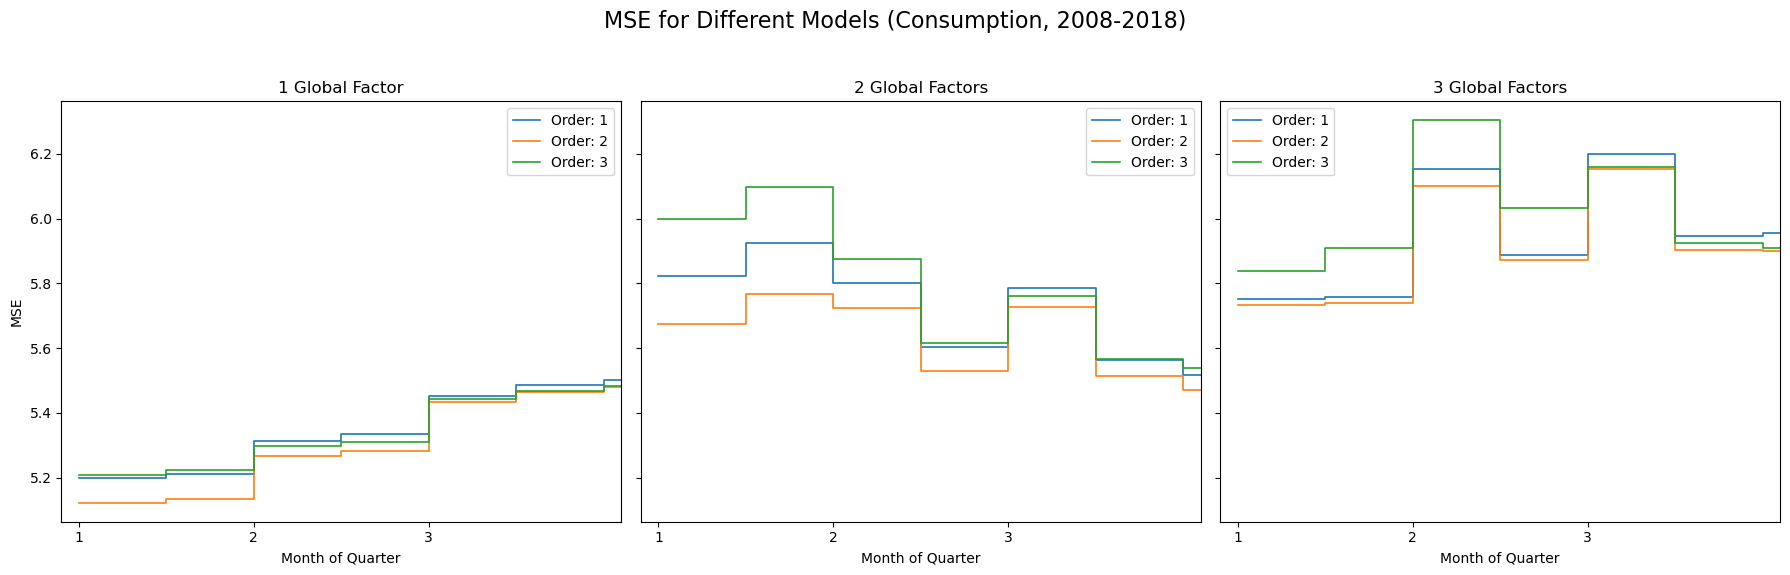

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'  

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_hard_surveys_global_factors_{q_var}_update"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_hard_surveys_global_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_hard_surveys_global_factors_{q_var}_update", f"DFM_hard_surveys_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


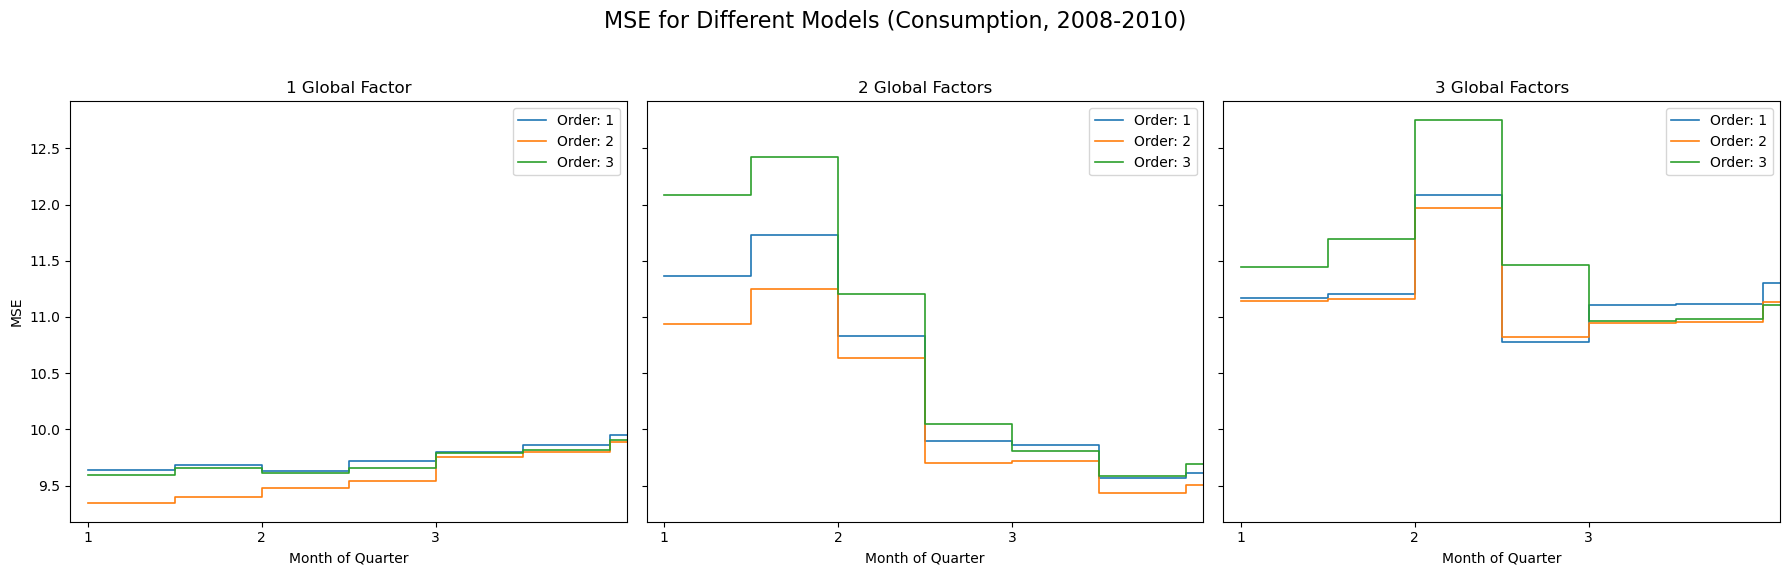

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


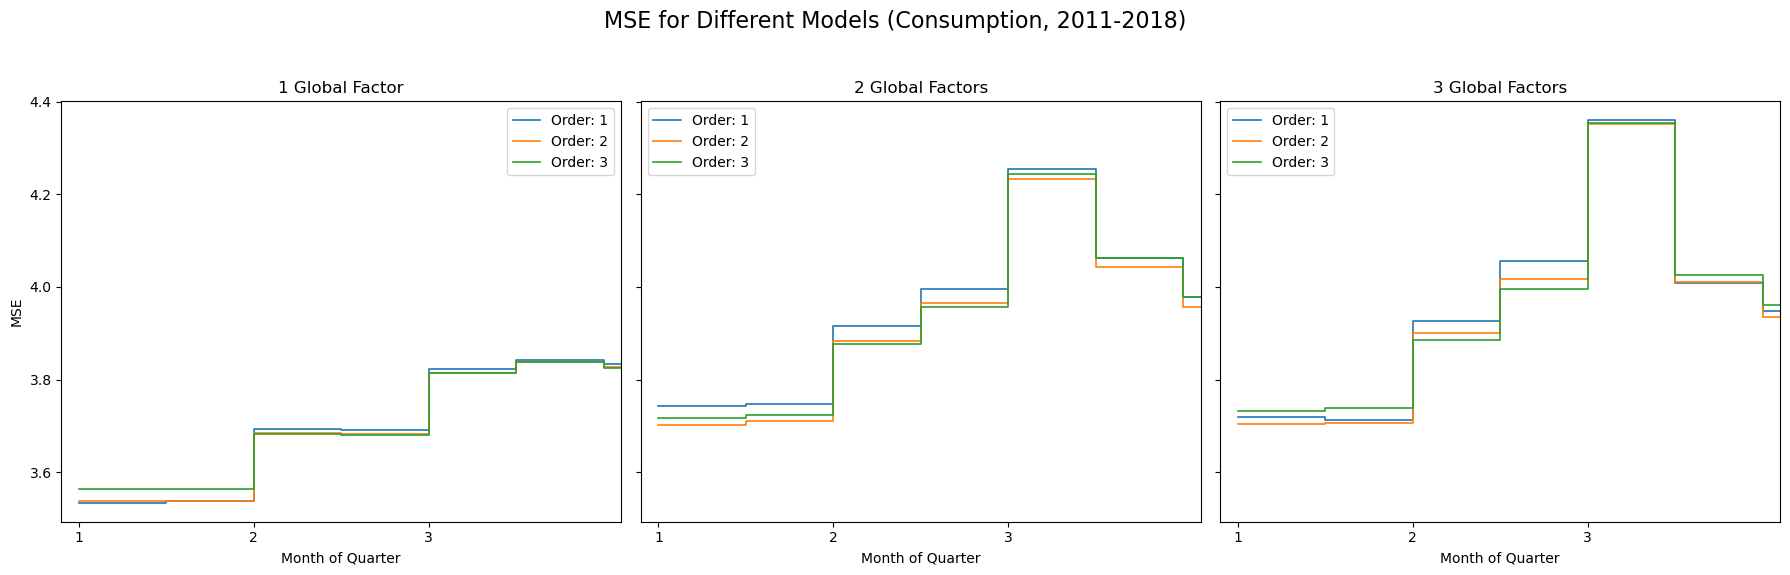

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
forecasts_dir = f"../forecasts/DFM_hard_surveys_global_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_hard_surveys_global_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_hard_surveys_global_factors_{q_var}_update", f"DFM_hard_surveys_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


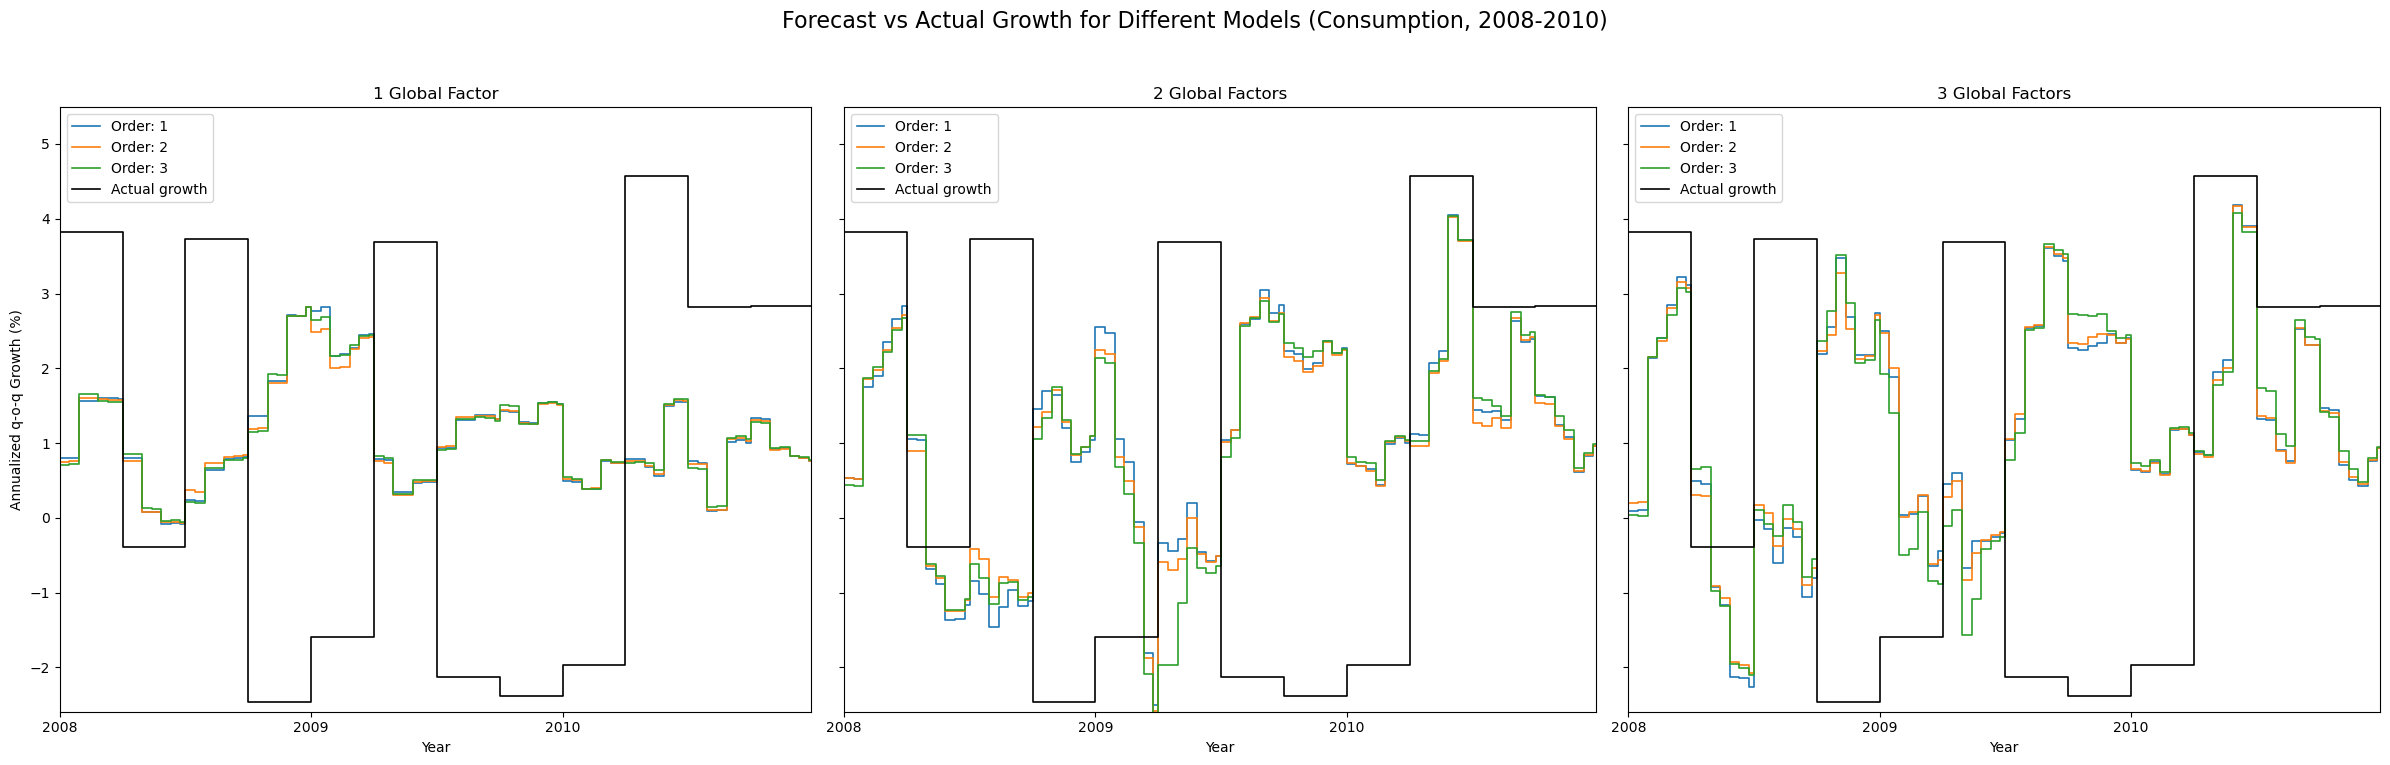

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


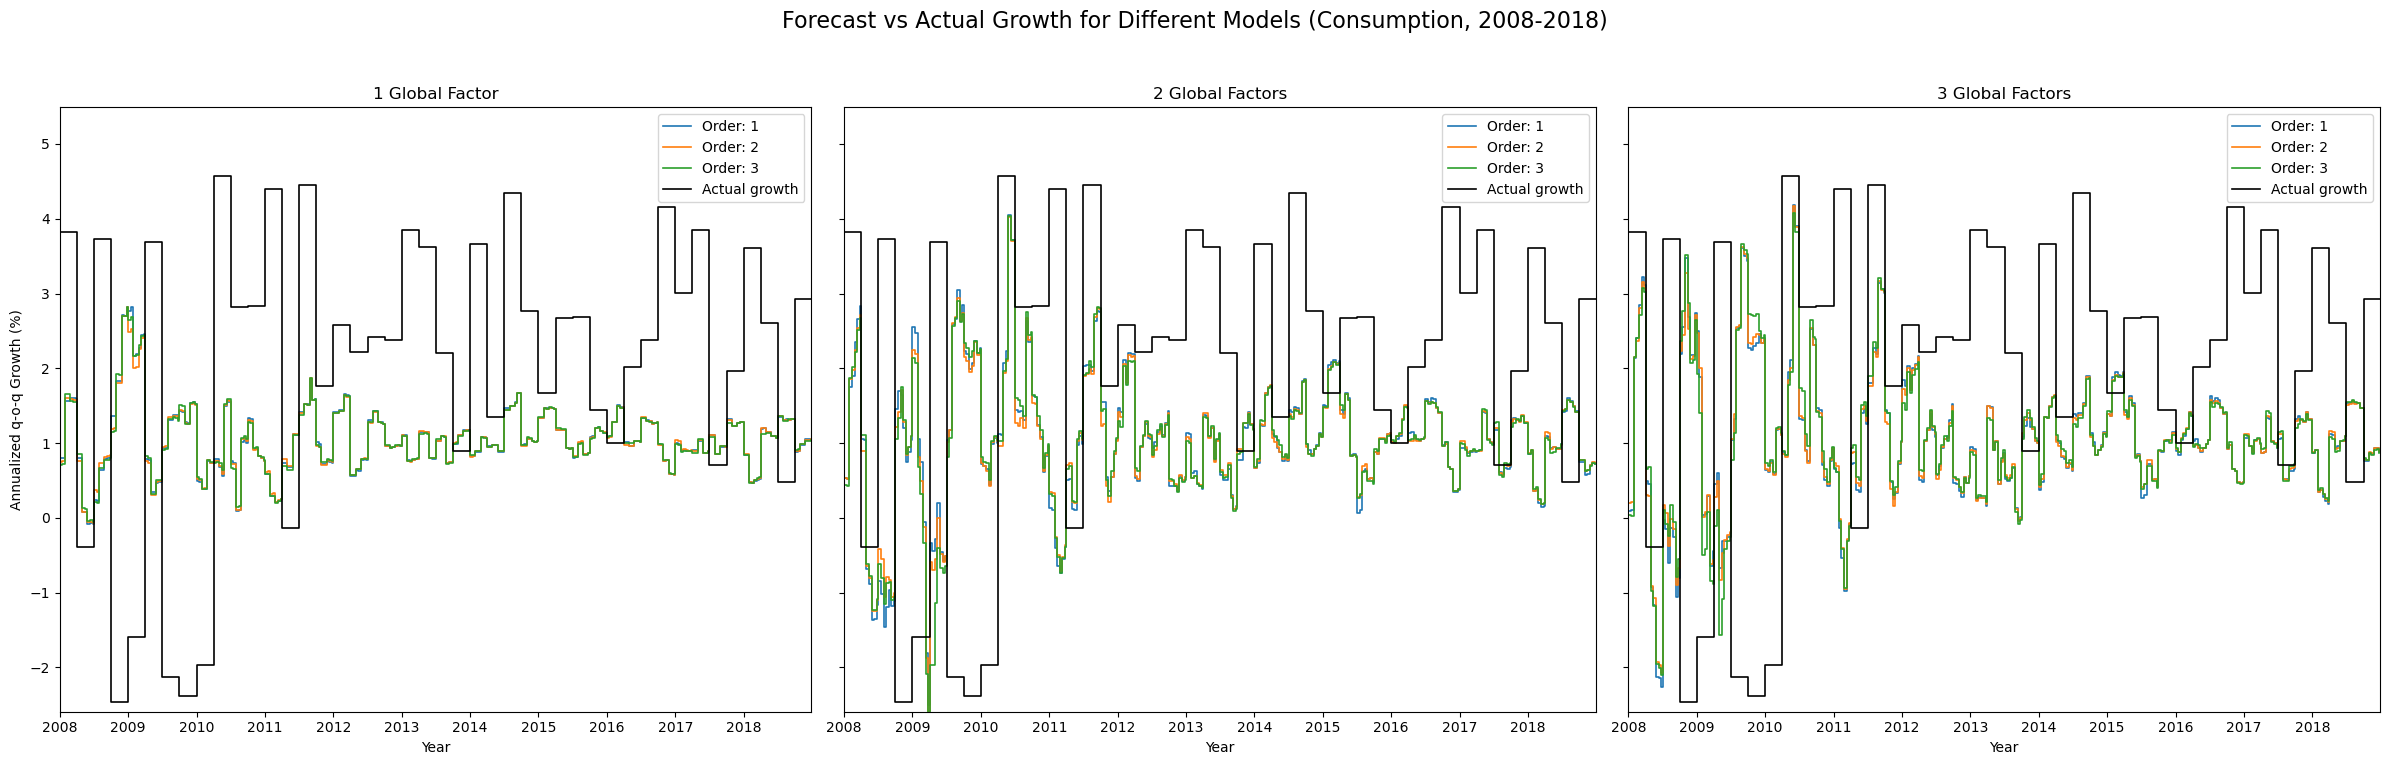

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


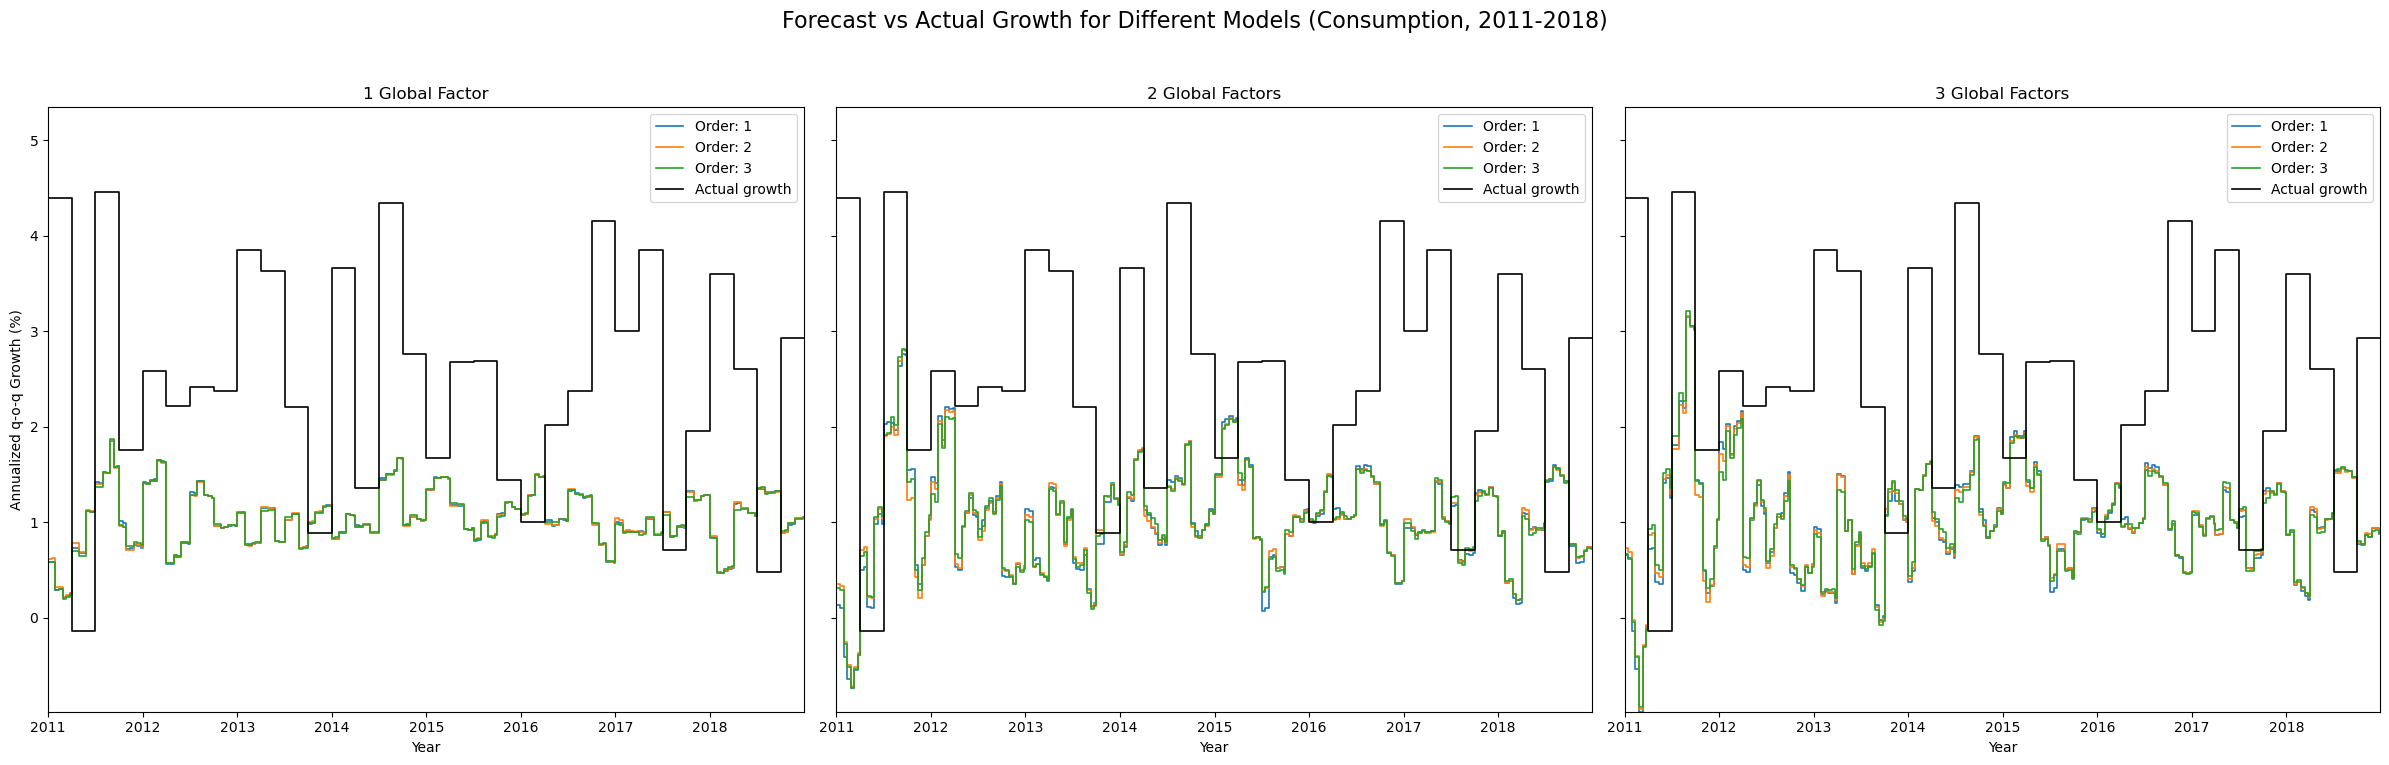

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
forecasts_dir = f"../forecasts/DFM_hard_surveys_global_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_hard_surveys_global_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_hard_surveys_global_factors_{q_var}_update", f"DFM_hard_surveys_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()